# Sentiment Analysis using RNN on IMDb reviews dataset
## Author: Ankit Gupta

In [ ]:
# Importing the data into a Pandas DataFrame after downloading and extracting the IMDb movie review dataset

import pandas as pd
import os

labels = {'pos':1, 'neg':0}
df = pd.DataFrame()

for s in ('test', 'train'):
    for l in ('pos', 'neg'):
        path ='./datasets/imdb/%s/%s' % (s, l)
        for file in os.listdir(path):
            with open(os.path.join(path, file), 'r') as infile:
                txt = infile.read()
            df = df.append([[txt, labels[l]]], ignore_index=True)
            
df.columns = ['review', 'sentiment']

In [28]:
# Preparing a .csv file using the DataFrame

import numpy as np

np.random.seed(0)
perm = np.random.permutation(len(df))
df = df.reindex(np.random.permutation(df.index))
df = df.iloc[perm]
df.to_csv('./datasets/imdb/movie_data.csv', index=False)

In [1]:
df = pd.read_csv('./datasets/imdb/movie_data.csv')
df.tail()

,review,sentiment
49995,Terrible!!! I don't want to be too negative bu...,0
49996,Why can't more directors these days create hor...,1
49997,A `Wacky Chick' flick. A beauty contestant win...,0
49998,I'd have little to add to bowlofsoul23's bull'...,0
49999,Underwoods goofy story about a young man(Arque...,0


In [6]:
print(df.iloc[-50, 0])

A brilliant horror film. Utterly gruesome and very scary too. The Thing is a remake from John Carpenter, but please, do not let that put you off this film. It is simply brilliant. The start of the film has the alien's spacecraft hurtling towards the Earth centuries before mankind walked the planet with an explosion that unleashes the film's title in amazing shining white and blue stating 'THE THING'. One of the best opening credits for a horror film ever.<br /><br />The cast of actors who play the twelve man science team are a joy to behold and the locations for the setting of their Station in Antartica is visually impressive on DVD widescreen. It must have been great in the cinema. I regret not seeing this on the big screen.<br /><br />Kurt Russell is excellent as Macready, the helicopter pilot who reluctantly becomes the leader of the men trying to combat a lethal shape changing monstrosity that has infiltrated their base. All the actors in this are really good and create terrific sc

In [2]:
words = []

for i in range(len(df)):
    words += df.iloc[i, 0].split()

In [3]:
# build the label mapping

from collections import Counter

vocabulary = Counter(words) # builds a dict with keys as distict words and their counts in the list as vals
print(len(vocabulary))

# extract out 50000 most commonly occuring words
vocabulary_size = 50000-1
vocabulary = [word for (word, count) in vocabulary.most_common(vocabulary_size)]

# adding a string for padding
vocabulary = np.array(['<pad>'] + vocabulary)
print(len(vocabulary), '\n', vocabulary)

label = {}
for i in range(len(vocabulary)):
    label[vocabulary[i]] = i

438729
50000 
 ['<pad>' 'the' 'a' ..., 'me....' 'chains,' 'dog"']


In [73]:
# sequences with < 200 valid words will be left padded with 0's
# sequences with > 200 valid words will cut so that only last 200 valid words are used
# encoding the dataset

from bisect import bisect_left

def search(x, a):
    'Locate the leftmost value exactly equal to x'
    i = bisect_left(a, x)
    return(i != len(a) and a[i] == x)

sequence_length = 200
data_encoded = np.zeros((len(df), sequence_length)) 
vocabulary_sorted = sorted(vocabulary)

for i in range(len(df)):
    word_list = df.iloc[i, 0].split()
    n_valid_seen = 0
    for j in range(len(word_list)-1, -1, -1):
        if n_valid_seen == sequence_length:
            break
        if search(word_list[j], vocabulary_sorted):
            data_encoded[i, -n_valid_seen - 1] = label[word_list[j]]
            n_valid_seen += 1

In [74]:
X_train, y_train = data_encoded[:25000].astype('int32'), df.iloc[:25000, 1].values.astype('int32')
X_test, y_test = data_encoded[25000:].astype('int32'), df.iloc[25000:, 1].values.astype('int32')

In [93]:
# creating an embedding matrix, and constructing the RNN

import tensorflow as tf

embedding_size = 256

n_inputs = 1
n_layers = 1
n_neurons = 128
keep_prob = 0.6

tf.reset_default_graph()

embeddings = tf.Variable(np.random.uniform(-1, 1, (len(vocabulary), embedding_size)), dtype='float32')

X = tf.placeholder(dtype='int32', shape=(None, sequence_length), name='X')
y = tf.placeholder(dtype='int32', shape=(None), name='y')

# as the embedding themselves change during the training we use tf's embedding_lookup()
X_embedded = tf.nn.embedding_lookup(embeddings, X)

keep_prob_ph = tf.placeholder(dtype='float32', shape=None, name='keep_prob_ph')

layers = []
for i in range(n_layers):
    gru_cell = tf.nn.rnn_cell.GRUCell(n_neurons, activation=tf.nn.tanh)
    cell_with_dropout = tf.nn.rnn_cell.DropoutWrapper(gru_cell, output_keep_prob=keep_prob_ph, dtype='float32')
    layers.append(cell_with_dropout)  

multi_cell = tf.nn.rnn_cell.MultiRNNCell(layers)
outputs, states = tf.nn.dynamic_rnn(multi_cell, X_embedded, dtype='float32')
logits = tf.layers.dense(states[-1], 2, name='logits')

#loss
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y)
loss = tf.reduce_mean(xentropy)

#training op
optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
training_op = optimizer.minimize(loss)

#eval
correct = tf.nn.in_top_k(logits, y, k=1)
accuracy = tf.reduce_mean(tf.cast(correct, dtype='float32'))

# saver
saver = tf.train.Saver()

init = tf.global_variables_initializer()

In [94]:
def get_next_batch(epoch, batch, batch_size):
    np.random.seed(epoch)
    perm = np.random.permutation(len(X_train))
    indices = perm[batch*batch_size: (1+batch)*batch_size]
    return X_train[indices], y_train[indices]

n_epochs = 3
batch_size = 100

sess = tf.InteractiveSession()
init.run()

for epoch in range(n_epochs):
    for batch in range(len(X_train) // batch_size):
        X_batch, y_batch = get_next_batch(epoch, batch, batch_size)
        sess.run(training_op, feed_dict={X: X_batch, y: y_batch, keep_prob_ph: keep_prob})
        # print accuracy
        if batch % 50 == 0:
            print('train accuracy', accuracy.eval(feed_dict={X: X_batch, y: y_batch, keep_prob_ph: 1}), 
                  'test accuracy', accuracy.eval(feed_dict={X: X_test[:1000], y: y_test[:1000], keep_prob_ph: 1})
                 )

#sess.close()
# without dropout it overfits

train accuracy 0.66 test accuracy 0.53
train accuracy 0.71 test accuracy 0.646
train accuracy 0.75 test accuracy 0.773
train accuracy 0.73 test accuracy 0.792
train accuracy 0.84 test accuracy 0.833
train accuracy 0.94 test accuracy 0.853
train accuracy 0.86 test accuracy 0.854
train accuracy 0.88 test accuracy 0.869
train accuracy 0.91 test accuracy 0.869
train accuracy 0.96 test accuracy 0.879
train accuracy 0.98 test accuracy 0.868
train accuracy 0.97 test accuracy 0.882
train accuracy 0.99 test accuracy 0.874
train accuracy 0.99 test accuracy 0.879
train accuracy 0.95 test accuracy 0.872


'./datasets/sentiment_rnn'

In [95]:
# final test accuracy
# there's not enough memory to give it input of size 25000 so limit to 10000

print('test accuracy', accuracy.eval( feed_dict={X: X_test[:10000], y: y_test[:10000], keep_prob_ph: 1} ) )

test accuracy 0.8691


In [ ]:
# saving the model

saver.save(sess, './datasets/sentiment_rnn')

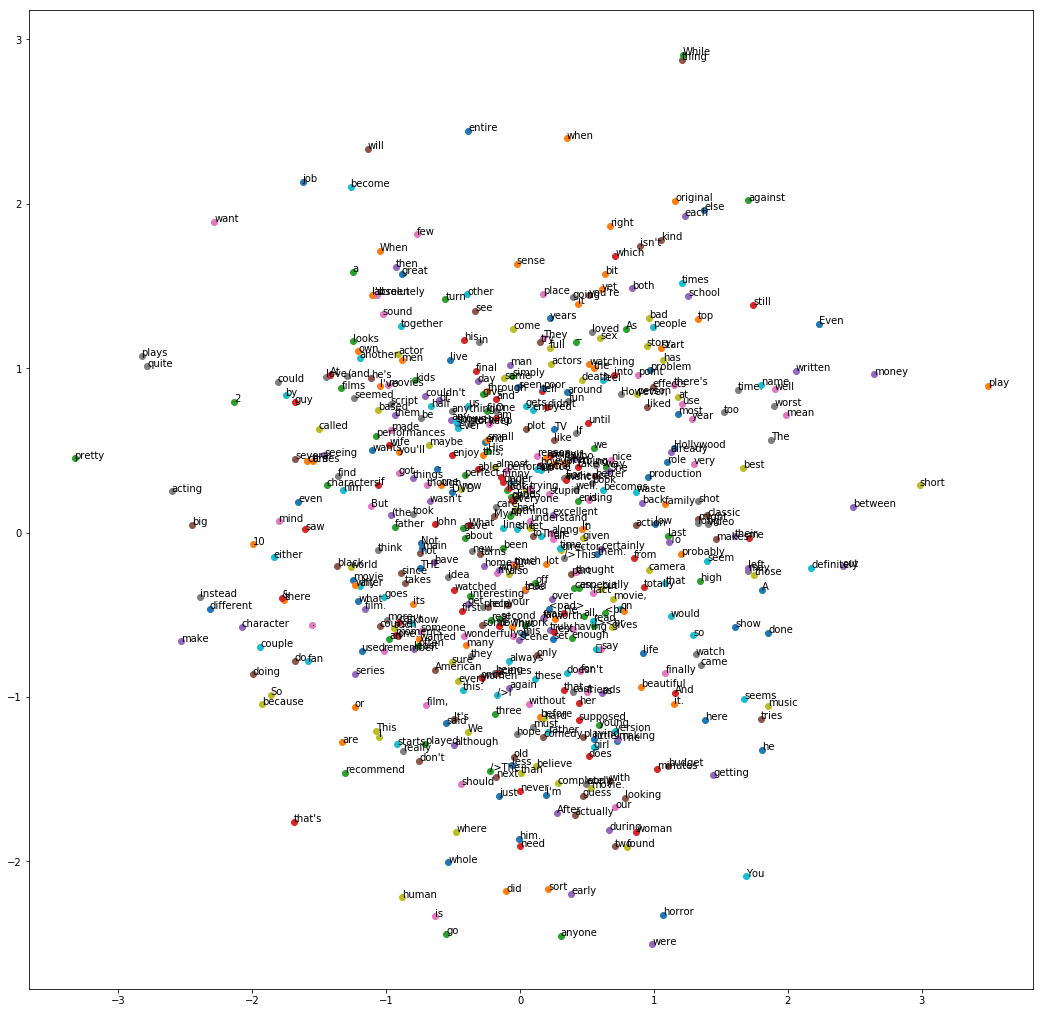

In [130]:
# visualize the embedding matrix
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
embeddings_2 = pca.fit_transform(embeddings.eval()[:plot_only])

plot_only = 500
plt.figure(figsize=(18, 18))

for i in range(plot_only):
    plt.plot(embeddings_2[i, 0], embeddings_2[i, 1], 'o', )
    plt.annotate(xy=(embeddings_2[i, 0], embeddings_2[i, 1]), s=vocabulary[i])
                #, xytext=(5, 2), textcoords='offset points', ha='right', va='bottom')

In [187]:
# testing
sess = tf.InteractiveSession()
saver.restore(sess, './datasets/sentiment_rnn')

s = 'I liked it.'
s_encoded = np.zeros((1, sequence_length)) 
word_list = s.split()
n_valid_seen = 0

for j in range(len(word_list)-1, -1, -1):
    if n_valid_seen == sequence_length:
        break
    if search(word_list[j], vocabulary_sorted):
        s_encoded[0, -n_valid_seen - 1] = label[word_list[j]]
        n_valid_seen += 1
        
s_logits = logits.eval( feed_dict={X: s_encoded, keep_prob_ph: 1} )[0] 
s_probs = tf.nn.softmax(s_logits).eval()
print('   -ve \t\t +ve')
print(s_probs)

if s_probs[0] > s_probs[1]:
    print('negative')
else:
    print('positive')

INFO:tensorflow:Restoring parameters from ./datasets/sentiment_rnn
   -ve 		 +ve
[ 0.12454519  0.87545478]
positive


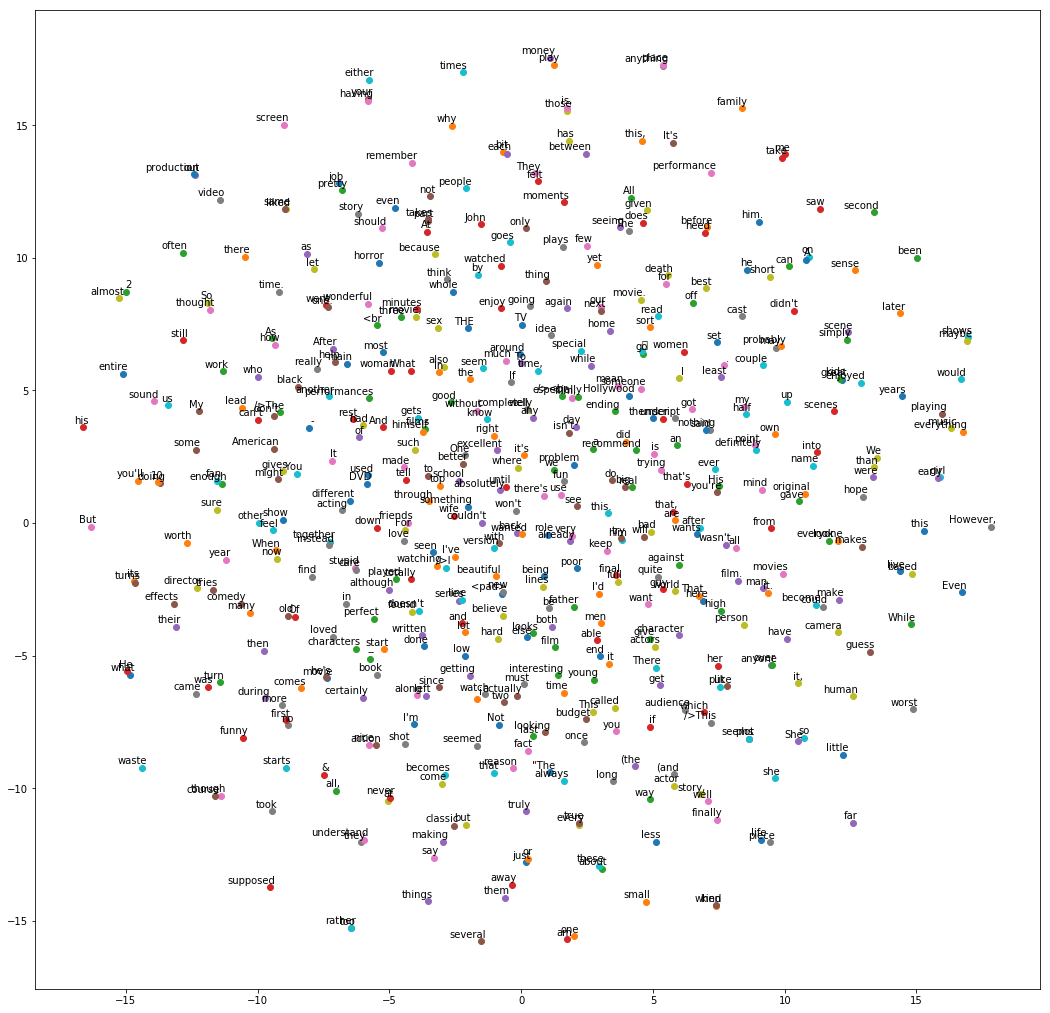

In [103]:
#from sklearn.manifold import TSNE

#def plot_with_labels(low_dim_embs, labels):
#    assert low_dim_embs.shape[0] >= len(labels), "More labels than embeddings"
#    plt.figure(figsize=(18, 18))  #in inches
#    for i, label in enumerate(labels):
#        x, y = low_dim_embs[i,:]
#        plt.scatter(x, y)
#        plt.annotate(label,
#                     xy=(x, y),
#                     xytext=(5, 2),
#                     textcoords='offset points',
#                     ha='right',
#                     va='bottom')

#tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
#plot_only = 500
#low_dim_embs = tsne.fit_transform(embeddings.eval()[:plot_only,:])
#labels = [vocabulary[i] for i in range(plot_only)]
#plot_with_labels(low_dim_embs, labels)